In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

import random as rd

SEED = 2026

In [2]:
def set_seed(seed): #Still data augmentation seed missing here (already set inside Albumentations)
  rd.seed(seed)              # Random
  np.random.seed(seed)       # NumPy
  torch.manual_seed(seed)    # PyTorch
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

set_seed(SEED)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

basepath = os.path.join(path, "kaggle_3m")
patients = [p for p in os.listdir(basepath) if os.path.isdir(os.path.join(basepath, p))]
patients.sort() #for reproducibility of results

TOTAL_PATIENTS = len(patients)

In [6]:
from sklearn.model_selection import train_test_split

#SPLIT 60-20-20

train_folder, remaining = train_test_split(patients, train_size=0.6, random_state=SEED)

val_folder, test_folder = train_test_split(remaining, train_size=0.5, random_state=SEED)

# Verify the count
print(f"Train Patients: {len(train_folder)} ({len(train_folder)/TOTAL_PATIENTS:.1%})")
print(f"Validation Patients: {len(val_folder)} ({len(val_folder)/TOTAL_PATIENTS:.1%})")
print(f"Test Patients: {len(test_folder)} ({len(test_folder)/TOTAL_PATIENTS:.1%})")

Train Patients: 66 (60.0%)
Validation Patients: 22 (20.0%)
Test Patients: 22 (20.0%)


In [7]:
#ASSERT THE SAME SPLIT ACROSS DIFFERENT EXPERIMENTS AND ARCHITECTURES

previous_train_folders = set(['TCGA_HT_7680_19970202', 'TCGA_DU_8165_19970205', 'TCGA_HT_7684_19950816', 'TCGA_HT_7616_19940813', 'TCGA_HT_7884_19980913', 'TCGA_HT_8107_19980708', 'TCGA_FG_5964_20010511', 'TCGA_HT_7874_19950902', 'TCGA_CS_6668_20011025', 'TCGA_CS_6666_20011109', 'TCGA_HT_7608_19940304', 'TCGA_HT_A5RC_19990831', 'TCGA_CS_6665_20010817', 'TCGA_CS_6669_20020102', 'TCGA_HT_7602_19951103', 'TCGA_DU_5871_19941206', 'TCGA_DU_A5TU_19980312', 'TCGA_FG_8189_20030516', 'TCGA_DU_7306_19930512', 'TCGA_DU_7008_19830723', 'TCGA_HT_7694_19950404', 'TCGA_FG_A4MU_20030903', 'TCGA_DU_A5TR_19970726', 'TCGA_DU_6408_19860521', 'TCGA_DU_7014_19860618', 'TCGA_DU_8164_19970111', 'TCGA_DU_5874_19950510', 'TCGA_CS_6188_20010812', 'TCGA_DU_7019_19940908', 'TCGA_DU_7018_19911220', 'TCGA_CS_4944_20010208', 'TCGA_FG_6688_20020215', 'TCGA_DU_7299_19910417', 'TCGA_HT_7882_19970125', 'TCGA_FG_7637_20000922', 'TCGA_HT_7860_19960513', 'TCGA_HT_8113_19930809', 'TCGA_HT_7605_19950916', 'TCGA_DU_8162_19961029', 'TCGA_FG_A4MT_20020212', 'TCGA_DU_5851_19950428', 'TCGA_DU_A5TY_19970709', 'TCGA_FG_6692_20020606', 'TCGA_DU_6399_19830416', 'TCGA_DU_7294_19890104', 'TCGA_DU_8163_19961119', 'TCGA_DU_7010_19860307', 'TCGA_DU_5854_19951104', 'TCGA_HT_7877_19980917', 'TCGA_CS_5397_20010315', 'TCGA_DU_6401_19831001', 'TCGA_HT_8114_19981030', 'TCGA_DU_A5TP_19970614', 'TCGA_CS_4943_20000902', 'TCGA_HT_8111_19980330', 'TCGA_HT_7473_19970826', 'TCGA_FG_7634_20000128', 'TCGA_DU_8166_19970322', 'TCGA_DU_6404_19850629', 'TCGA_DU_6405_19851005', 'TCGA_HT_8563_19981209', 'TCGA_HT_7475_19970918', 'TCGA_DU_A5TS_19970726', 'TCGA_DU_6400_19830518', 'TCGA_CS_5396_20010302', 'TCGA_CS_4942_19970222'])
previous_val_folders = set(['TCGA_CS_6667_20011105', 'TCGA_HT_7856_19950831', 'TCGA_HT_A61B_19991127', 'TCGA_HT_A61A_20000127', 'TCGA_FG_6689_20020326', 'TCGA_CS_5395_19981004', 'TCGA_DU_7300_19910814', 'TCGA_DU_8168_19970503', 'TCGA_CS_6290_20000917', 'TCGA_EZ_7264_20010816', 'TCGA_DU_8167_19970402', 'TCGA_HT_8105_19980826', 'TCGA_DU_7298_19910324', 'TCGA_DU_A5TW_19980228', 'TCGA_HT_A616_19991226', 'TCGA_DU_7309_19960831', 'TCGA_DU_5872_19950223', 'TCGA_CS_4941_19960909', 'TCGA_FG_A60K_20040224', 'TCGA_HT_8106_19970727', 'TCGA_CS_5393_19990606', 'TCGA_FG_7643_20021104'])
print(previous_train_folders == set(train_folder))
print(previous_val_folders == set(val_folder))
print(train_folder)
print(val_folder)

True
True
['TCGA_HT_7680_19970202', 'TCGA_DU_8165_19970205', 'TCGA_HT_7684_19950816', 'TCGA_HT_7616_19940813', 'TCGA_HT_7884_19980913', 'TCGA_HT_8107_19980708', 'TCGA_FG_5964_20010511', 'TCGA_HT_7874_19950902', 'TCGA_CS_6668_20011025', 'TCGA_CS_6666_20011109', 'TCGA_HT_7608_19940304', 'TCGA_HT_A5RC_19990831', 'TCGA_CS_6665_20010817', 'TCGA_CS_6669_20020102', 'TCGA_HT_7602_19951103', 'TCGA_DU_5871_19941206', 'TCGA_DU_A5TU_19980312', 'TCGA_FG_8189_20030516', 'TCGA_DU_7306_19930512', 'TCGA_DU_7008_19830723', 'TCGA_HT_7694_19950404', 'TCGA_FG_A4MU_20030903', 'TCGA_DU_A5TR_19970726', 'TCGA_DU_6408_19860521', 'TCGA_DU_7014_19860618', 'TCGA_DU_8164_19970111', 'TCGA_DU_5874_19950510', 'TCGA_CS_6188_20010812', 'TCGA_DU_7019_19940908', 'TCGA_DU_7018_19911220', 'TCGA_CS_4944_20010208', 'TCGA_FG_6688_20020215', 'TCGA_DU_7299_19910417', 'TCGA_HT_7882_19970125', 'TCGA_FG_7637_20000922', 'TCGA_HT_7860_19960513', 'TCGA_HT_8113_19930809', 'TCGA_HT_7605_19950916', 'TCGA_DU_8162_19961029', 'TCGA_FG_A4MT_

In [8]:
import shutil

dataset_dir = "/content/dataset"
os.makedirs(dataset_dir, exist_ok=True)

# --- Setup Output Directories ---
splits = {
    'train': train_folder,
    'val': val_folder,
    'test': test_folder
}

for split_name in splits.keys():
    os.makedirs(os.path.join(dataset_dir, split_name), exist_ok=True)

# --- Move/Copy Folders ---
for split_name, patient_list in splits.items():
    dest_dir = os.path.join(dataset_dir, split_name)

    for patient_folder_name in patient_list:
        src_path = os.path.join(basepath, patient_folder_name)
        dest_path = os.path.join(dest_dir, patient_folder_name)

        # Use shutil.copytree for copying the entire directory, including all MRI slices.
        # Use shutil.move if you prefer to physically move the folder instead of copying.
        shutil.copytree(src_path, dest_path, dirs_exist_ok=True)

print("\nPatient-Level Splitting Complete!")


Patient-Level Splitting Complete!


In [9]:
#Split the folders in img_folders and mask_folders (labels)

for split_name, patient_list in splits.items():
  temp_base_path = os.path.join(dataset_dir, split_name)

  for patient in patient_list:
    img_dest_dir = os.path.join(temp_base_path, patient, "images")
    mask_dest_dir = os.path.join(temp_base_path, patient, "mask")
    os.makedirs(img_dest_dir, exist_ok=True)
    os.makedirs(mask_dest_dir, exist_ok=True)

    files = [f for f in os.listdir(os.path.join(temp_base_path, patient)) if not os.path.isdir(os.path.join(temp_base_path, patient, f))]

    for f in files:
      src_path = os.path.join(temp_base_path, patient, f)
      if "_mask" in f:
        dst_path = os.path.join(mask_dest_dir, f)
      else:
        dst_path = os.path.join(img_dest_dir, f)

      shutil.copy2(src_path, dst_path)

print("✅ Files successfully sorted into 'images/' and 'masks/' folders.")

✅ Files successfully sorted into 'images/' and 'masks/' folders.


In [10]:
import re

def extract_slice_id(filename):
    name = os.path.splitext(filename)[0]      # remove .tif
    if name.endswith("_mask"):
        name = name[:-5]                      # remove _mask
    m = re.search(r"(\d+)$", name)            # trailing digits
    return int(m.group(1)) if m else None

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. Define the augmentation pipeline
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        rotate=(-15, 15),
        scale=(0.9, 1.1),
        shear=(-10, 10),
        p=0.7,
        interpolation=1,      # 1 = cv2.INTER_LINEAR (for image)
        mask_interpolation=0  # 0 = cv2.INTER_NEAREST (for mask)
    ),
    A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),

    # Pixel-level transforms are applied ONLY to the image by default
    #A.ColorJitter(brightness=0.3, contrast=0.3, p=0.5),
    #A.GaussianBlur(blur_limit=(3, 7), p=0.3),

    ToTensorV2() # Converts numpy image/mask to PyTorch tensors
], seed=SEED)

/tmp/ipython-input-281538261.py:15: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),


In [12]:
class MRISegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path to train/val/test directory containing patient folders
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Loop through each patient folder
        for patient_name in sorted(os.listdir(root_dir)):
            patient_path = os.path.join(root_dir, patient_name)
            images_dir = os.path.join(patient_path, "images")
            masks_dir  = os.path.join(patient_path, "mask")

            if not os.path.isdir(images_dir) or not os.path.isdir(masks_dir):
              print(f"WARNING: {images_dir} or {masks_dir} is not a folder")
              continue  # skip malformed folders

            # sort both lists to maintain correspondence
            image_files = os.listdir(images_dir)
            mask_files = os.listdir(masks_dir)

            image_files.sort(key=lambda f: extract_slice_id(f))
            mask_files.sort(key=lambda f: extract_slice_id(f))

            # Ensure equal number of slices
            assert len(image_files) == len(mask_files), f"Mismatch in {patient_name}"

            # Pair each image with its matching mask
            for img_name, mask_name in zip(image_files, mask_files):
                # Optional: verify name correspondence (e.g. same slice number)
                if os.path.splitext(img_name)[0] not in mask_name:
                    print(f"Warning: potential mismatch {img_name} <-> {mask_name}")

                img_path = os.path.join(images_dir, img_name)
                mask_path = os.path.join(masks_dir, mask_name)
                self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]

        # Load
        image = np.array(Image.open(image_path), dtype=np.float32)
        mask  = np.array(Image.open(mask_path), dtype=np.float32)

        # Normalize per image
        image = (image - image.min(axis=(0,1), keepdims=True)) / (image.max(axis=(0,1), keepdims=True) - image.min(axis=(0,1), keepdims=True) + 1e-8)

        #Binarize the mask
        mask = (mask > 0.5).astype(np.int64)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  #(C, H, W) tensor
            mask = augmented['mask']    #(H, W) tensor
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1))  # (3,H,W)
            mask  = torch.from_numpy(mask)

        # mask = mask.unsqueeze(0)  # Add 1 dimension for U-Net input (1,H,W)

        return image, mask

In [13]:
# Create Datasets
train_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, 'train'), transform=train_transform)
val_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, 'val'))
test_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, 'test'))

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2236
Validation dataset size: 869
Test dataset size: 824


Augmented image shape: torch.Size([3, 256, 256]), dtype: torch.float32
Augmented mask shape: torch.Size([256, 256]), dtype: torch.int32
Unique values in augmented mask: tensor([0, 1], dtype=torch.int32)
Sample data plot saved as 'segnet_sample_data.png'


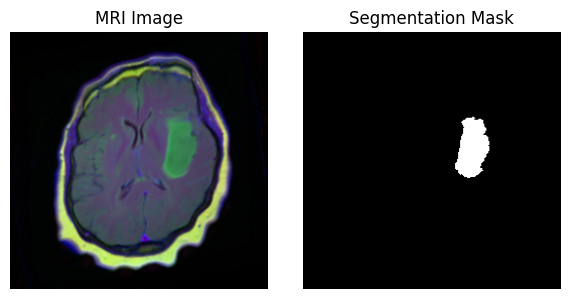

In [14]:
to_pil = transforms.ToPILImage()

img, mask = train_dataset.__getitem__(10) #The pair (image, mask) is the same but whenever we call __getitem__ a random transformation is applied
print(f"Augmented image shape: {img.shape}, dtype: {img.dtype}")
print(f"Augmented mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Unique values in augmented mask: {torch.unique(mask)}")

img = to_pil(img)
mask = to_pil(mask.float()) # Convert the mask to float for visualization

fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # 1 row, 2 columns

axes[0].imshow(img, cmap='gray')   # or cmap=None if it's RGB
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segnet_sample_data.png")
print("Sample data plot saved as 'segnet_sample_data.png'")

In [15]:
np_img = np.array(img)
print(np_img.shape)

(256, 256, 3)


In [16]:
import torchvision.models as models

# --- SEGNET MODEL DEFINITION (WITH PRE-TRAINED ENCODER) ---
class SegNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()

        # Load pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # === 1. ENCODER ===
        # Use the 'features' part of VGG16 as the encoder
        # We'll slice it into 5 blocks, just like SegNet

        # Block 1: 2 Conv + 1 Pool
        self.enc1 = nn.Sequential(*vgg16.features[0:5])
        # Block 2: 2 Conv + 1 Pool
        self.enc2 = nn.Sequential(*vgg16.features[5:10])
        # Block 3: 3 Conv + 1 Pool
        self.enc3 = nn.Sequential(*vgg16.features[10:17])
        # Block 4: 3 Conv + 1 Pool
        self.enc4 = nn.Sequential(*vgg16.features[17:24])
        # Block 5: 3 Conv + 1 Pool
        self.enc5 = nn.Sequential(*vgg16.features[24:31])

        # We need to use nn.MaxPool2d with return_indices=True
        # So we replace the VGG MaxPool layers with our own
        # Note: The VGG model structure might change, but as of now:
        # 4, 9, 16, 23, 30 are the MaxPool2d layers in vgg16.features
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc1[4] = self.pool
        self.enc2[4] = self.pool
        self.enc3[6] = self.pool
        self.enc4[6] = self.pool
        self.enc5[6] = self.pool

        # === 2. DECODER ===
        # The decoder remains the same as your original, no pre-training here
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # We keep your _make_dec_block helper function
        self.dec5 = self._make_dec_block(512, 512, 3)
        self.dec4 = self._make_dec_block(512, 256, 3)
        self.dec3 = self._make_dec_block(256, 128, 3)
        self.dec2 = self._make_dec_block(128, 64, 2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    # This helper function is now ONLY for the decoder
    def _make_dec_block(self, in_ch, out_ch, num_convs):
        layers = []
        current_in_ch = in_ch
        for i in range(num_convs):
            layers.append(nn.Conv2d(current_in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.ReLU(inplace=True))
            # We keep the dropout for regularization
            if i < num_convs - 1:
                layers.append(nn.Dropout2d(p=0.3))
            current_in_ch = out_ch
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder with indices collection
        idxs = []
        shapes = []

        # We must call the pool layers separately to get indices
        # This is a bit manual but required for SegNet

        # Enc1
        x = self.enc1[0:4](x) # Conv layers
        shapes.append(x.size())
        x, ind1 = self.enc1[4](x); idxs.append(ind1) # Pool layer

        # Enc2
        x = self.enc2[0:4](x)
        shapes.append(x.size())
        x, ind2 = self.enc2[4](x); idxs.append(ind2)

        # Enc3
        x = self.enc3[0:6](x)
        shapes.append(x.size())
        x, ind3 = self.enc3[6](x); idxs.append(ind3)

        # Enc4
        x = self.enc4[0:6](x)
        shapes.append(x.size())
        x, ind4 = self.enc4[6](x); idxs.append(ind4)

        # Enc5
        x = self.enc5[0:6](x)
        shapes.append(x.size())
        x, ind5 = self.enc5[6](x); idxs.append(ind5)

        # --- Decoder ---
        x = self.unpool(x, idxs.pop(), output_size=shapes.pop())
        x = self.dec5(x)

        x = self.unpool(x, idxs.pop(), output_size=shapes.pop())
        x = self.dec4(x)

        x = self.unpool(x, idxs.pop(), output_size=shapes.pop())
        x = self.dec3(x)

        x = self.unpool(x, idxs.pop(), output_size=shapes.pop())
        x = self.dec2(x)

        x = self.unpool(x, idxs.pop(), output_size=shapes.pop())
        x = self.dec1(x)

        return x

In [17]:
# --- EARLY STOPPING CLASS ---
# (Copied from your U-Net notebook)
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [18]:
# --- LOSS FUNCTIONS ---
# --- ADD ALL OF THIS TO CELL 16 ---

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - torch.cumsum(gt_sorted, dim=0)
    union = gts + torch.cumsum(1.0 - gt_sorted, dim=0)
    jaccard = 1.0 - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (1-D)
      classes: 'all' for all classes, 'present' for classes present in labels
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.0
    C = probas.shape[1]
    losses = []
    class_to_sum = list(range(C)) if classes == 'all' else torch.unique(labels)
    for c in class_to_sum:
        gt_c = (labels == c).float()  # [P]
        if gt_c.sum() == 0:
            continue
        probas_c = probas[:, c]
        errors = (gt_c - probas_c).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        gt_c_sorted = gt_c[perm]
        losses.append(torch.dot(errors_sorted, lovasz_grad(gt_c_sorted)))
    return torch.stack(losses).mean()

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each pixel (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels
    """
    if per_image:
        loss = torch.mean(
            torch.stack(
                [lovasz_softmax_flat(
                    probas_one.permute(1, 2, 0).contiguous().view(-1, C),
                    labels_one.view(-1),
                    classes=classes)
                 for probas_one, labels_one in zip(probas, labels)
                ]
            )
        )
    else:
        labels = labels.view(-1)
        probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, probas.shape[1])
        loss = lovasz_softmax_flat(probas, labels, classes=classes)
    return loss

# This is the multi-class Dice loss function you asked for.
# It takes 2-channel logits and calculates Dice for the tumor class (class 1).
def dice_loss(pred_logits, target_long, eps=1e-6):
    """
    pred_logits: (N, C, H, W)
    target_long: (N, H, W)
    """
    num_classes = pred_logits.shape[1]

    # Convert target_long to one-hot
    target_one_hot = torch.nn.functional.one_hot(target_long, num_classes).permute(0, 3, 1, 2).float()

    # Apply softmax to logits to get probabilities
    pred_probs = torch.softmax(pred_logits, dim=1)

    # Calculate intersection and union for each class (except background class 0)
    # We use [:, 1:, :, :] to keep the dimension, shape is (N, 1, H, W)
    dims = (0, 2, 3) # Sum over batch, height, width
    intersection = (pred_probs[:, 1:, :, :] * target_one_hot[:, 1:, :, :]).sum(dim=dims)
    union = pred_probs[:, 1:, :, :].sum(dim=dims) + target_one_hot[:, 1:, :, :].sum(dim=dims)

    dice = (2. * intersection + eps) / (union + eps)

    # We average the dice score over the non-background classes (here, just class 1)
    return 1 - dice.mean()

def combined_loss(pred_logits, target_long, criterion_ce):
    # pred_logits: (N, 2, H, W) - raw logits from SegNet
    # target_long: (N, H, W) - ground truth class indices (0 or 1)

    # 1. Cross-Entropy Loss term (for smooth gradients)
    ce_loss_term = criterion_ce(pred_logits, target_long.long())

    # 2. Lovasz-Softmax Loss term (to directly optimize IoU)
    # We must pass probabilities (after softmax) to lovasz_softmax
    pred_probs = torch.softmax(pred_logits, dim=1)
    lovasz_loss_term = lovasz_softmax(pred_probs, target_long)

    # We can try a 50/50 mix since Lovasz is so powerful
    return 0.5 * ce_loss_term + 0.5 * lovasz_loss_term

In [ ]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Hyperparameters for the single run
LEARNING_RATE = 1e-5
# CHANGED: Reduced BATCH_SIZE from 8 to 4 to fix OutOfMemoryError
BATCH_SIZE = 16
NUM_EPOCHS = 30 # Set to a reasonable number, EarlyStopping will handle the rest
PATIENCE = 5   # Number of epochs to wait for improvement

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, criterion, optimizer
model = SegNet(in_channels=3, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path='segnet_checkpoint.pt')

train_loss_list = []
val_loss_list = []

print("--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    # --- TRAINING STAGE ---
    model.train()
    train_loss = 0.0

    # Using tqdm for the training loop
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device) # masks are (N, H, W) long

        optimizer.zero_grad()
        outputs = model(imgs) # outputs are now raw logits (N, 2, H, W)
        loss = combined_loss(outputs, masks, criterion)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    # --- VALIDATION STAGE ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs) # outputs are now raw logits (N, 2, H, W)
            loss = combined_loss(outputs, masks, criterion)
            val_loss += loss.item() * imgs.size(0)

    # --- EPOCH END ---
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] \t Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early Stopping!")
        break

print("--- Training Complete ---")

Using device: cuda
--- Starting Training ---


Epoch 1/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [1/30] 	 Train Loss: 0.7265 	 Val Loss: 0.6604
Validation loss decreased (inf --> 0.660416).  Saving model ...


Epoch 2/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [2/30] 	 Train Loss: 0.5488 	 Val Loss: 0.4815
Validation loss decreased (0.660416 --> 0.481482).  Saving model ...


Epoch 3/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [3/30] 	 Train Loss: 0.4550 	 Val Loss: 0.4220
Validation loss decreased (0.481482 --> 0.422022).  Saving model ...


Epoch 4/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [4/30] 	 Train Loss: 0.3964 	 Val Loss: 0.3682
Validation loss decreased (0.422022 --> 0.368201).  Saving model ...


Epoch 5/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [5/30] 	 Train Loss: 0.3581 	 Val Loss: 0.3438
Validation loss decreased (0.368201 --> 0.343762).  Saving model ...


Epoch 6/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [6/30] 	 Train Loss: 0.3377 	 Val Loss: 0.3216
Validation loss decreased (0.343762 --> 0.321612).  Saving model ...


Epoch 7/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [7/30] 	 Train Loss: 0.3185 	 Val Loss: 0.3071
Validation loss decreased (0.321612 --> 0.307074).  Saving model ...


Epoch 8/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [8/30] 	 Train Loss: 0.3070 	 Val Loss: 0.2954
Validation loss decreased (0.307074 --> 0.295433).  Saving model ...


Epoch 9/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [9/30] 	 Train Loss: 0.2940 	 Val Loss: 0.2782
Validation loss decreased (0.295433 --> 0.278231).  Saving model ...


Epoch 10/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [10/30] 	 Train Loss: 0.2840 	 Val Loss: 0.2648
Validation loss decreased (0.278231 --> 0.264756).  Saving model ...


Epoch 11/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch [11/30] 	 Train Loss: 0.2751 	 Val Loss: 0.2582
Validation loss decreased (0.264756 --> 0.258241).  Saving model ...


Epoch 12/30 [Train]:   0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
# --- PLOT TRAINING & VALIDATION LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss', marker='o')
plt.plot(val_loss_list, label='Validation Loss', marker='x')
plt.title('Training vs. Validation Loss per Epoch (SegNet)')
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.legend()
plt.grid(True)
plt.savefig('segnet_loss_curve.png')
print("Loss curve saved as 'segnet_loss_curve.png'")

In [ ]:
# --- TEST SET EVALUATION ---
# Load the best model saved by EarlyStopping
model.load_state_dict(torch.load('segnet_checkpoint.pt'))

test_loss = 0.0
all_imgs = []
all_preds = []
all_gts = [] #ground truths

model.eval()

with torch.no_grad():
  for imgs, masks in tqdm(test_loader, desc="Testing"):
    imgs, masks = imgs.to(device), masks.to(device)

    outputs = model(imgs) # (N, 2, H, W) logits

    loss = combined_loss(outputs, masks, criterion)
    test_loss += loss.item() * imgs.size(0)

    # Store logits for preds, we'll process them on CPU
    all_imgs.append(imgs.cpu())
    all_preds.append(outputs.cpu())
    all_gts.append(masks.cpu())

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

imgs_all = torch.cat(all_imgs)
preds_all = torch.cat(all_preds) # All predictions (logits)
gts_all   = torch.cat(all_gts)   # All ground truths (long)

# Get binary predictions (class indices) from logits
# shape will be (N, H, W)
binary_preds = torch.argmax(preds_all, dim=1)

In [ ]:
# --- COMPUTE FINAL SCORES ---
def compute_scores(pred, target, eps=1e-6):
    """
    Computes Accuracy, IoU, and Dice for class 1 (tumor)
    pred: (N, H, W) tensor of predicted class indices (long)
    target: (N, H, W) tensor of ground truth class indices (long)
    """
    # Accuracy
    accuracy = (pred == target).float().mean().item()

    # Prepare for IoU and Dice (for class 1)
    pred_class = (pred == 1).float()
    target_class = (target == 1).float()

    inter = (pred_class * target_class).sum()
    union_set = pred_class.sum() + target_class.sum()

    # IoU = Inters / (Union - Inters)
    iou = (inter + eps) / (union_set - inter + eps)

    # Dice = 2 * Inters / Union
    dice = (2 * inter + eps) / (union_set + eps)

    return accuracy, iou.item(), dice.item()

accuracy, iou, dice = compute_scores(binary_preds, gts_all)

print(f"Test Set Dice Coefficient: {dice:.4f}")
print(f"Test Set IoU: {iou:.4f}")
print(f"Test Set Pixel Accuracy: {accuracy:.4f}")

In [ ]:
# --- VISUALIZE PREDICTIONS ---
# Convert tensors to PIL images for plotting
imgs_to_plot = [to_pil(img) for img in imgs_all]
# We plot the float version of the mask (0.0 or 1.0)
gts_to_plot = [to_pil(gt.float()) for gt in gts_all]
preds_to_plot = [to_pil(pred.float()) for pred in binary_preds]

interval = len(imgs_to_plot)
idx = rd.randint(0, interval-1)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns

axes[0].imshow(imgs_to_plot[idx], cmap=None)   # or cmap=None if it's RGB
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(gts_to_plot[idx], cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis("off")

axes[2].imshow(preds_to_plot[idx], cmap='gray')
axes[2].set_title("SegNet Prediction")
axes[2].axis("off")

plt.tight_layout()
plt.savefig('segnet_prediction_sample.png')
print("Prediction sample saved as 'segnet_prediction_sample.png'")